In [1]:
import zipfile
import os
animal_zip_path = "/content/animal_dataset.zip"
extract_path = "/content/animal_dataset"
try:
    with zipfile.ZipFile(animal_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction successful!")
except zipfile.BadZipFile:
    print("Error: The file is not a valid zip file.")
if os.path.exists(extract_path):
    class_dirs = os.listdir(extract_path)
    print("Classes (folders) found in dataset:", class_dirs)



Extraction successful!
Classes (folders) found in dataset: ['animals', 'images']


In [7]:
import os
base_dir = "/content/animal_dataset/animals/animals"
class_folders = sorted(os.listdir(base_dir))
for cls in class_folders:
    class_path = os.path.join(base_dir, cls)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        print(f"📁 {cls}/ — {len(image_files)} images")
        for img in image_files[:5]:
            print(f"    └── {img}")

        if len(image_files) > 5:
            print(f"    └── ...")

📁 cats/ — 1000 images
    └── cats_00705.jpg
    └── cats_00828.jpg
    └── cats_00171.jpg
    └── cats_00751.jpg
    └── cats_00424.jpg
    └── ...
📁 dogs/ — 1000 images
    └── dogs_00455.jpg
    └── dogs_00704.jpg
    └── dogs_00424.jpg
    └── dogs_00569.jpg
    └── dogs_00263.jpg
    └── ...
📁 panda/ — 1000 images
    └── panda_00785.jpg
    └── panda_00044.jpg
    └── panda_00709.jpg
    └── panda_00150.jpg
    └── panda_00093.jpg
    └── ...


In [9]:
import os
base_dir = "/content/animal_dataset/animals/animals"
class_folders = sorted(os.listdir(base_dir))
# Count and print number of images in each class
for cls in class_folders:
    class_path = os.path.join(base_dir, cls)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{cls}: {num_images} images")


cats: 1000 images
dogs: 1000 images
panda: 1000 images


In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [12]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
data_dir = "/content/animal_dataset"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Class names:", dataset.classes)


Class names: ['animals', 'images']


In [13]:
dataset = datasets.ImageFolder("/content/animal_dataset", transform=transform)


In [14]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Split: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the sizes
print(f"Train size: {len(train_dataset)} | Test size: {len(test_dataset)}")


Train size: 4804 | Test size: 1202


In [15]:
# Define the CNN model
class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3x64x64, Output: 32x64x64
        self.pool = nn.MaxPool2d(2, 2)                           # Output: 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: 64x32x32 → pool → 64x16x16
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: cat, dog, panda

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pool
        x = x.view(-1, 64 * 16 * 16)          # Flatten
        x = F.relu(self.fc1(x))               # FC1 + ReLU
        x = self.fc2(x)                       # FC2 (logits)
        return x


In [22]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnimalCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# For tracking
num_epochs = 10
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)
    # Validation loop
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch [1/10] Train Loss: 0.0376, Train Acc: 99.92% | Val Loss: 0.0160, Val Acc: 99.92%
Epoch [2/10] Train Loss: 0.0088, Train Acc: 99.96% | Val Loss: 0.0248, Val Acc: 99.92%
Epoch [3/10] Train Loss: 0.0147, Train Acc: 99.96% | Val Loss: 0.0067, Val Acc: 99.92%
Epoch [4/10] Train Loss: 0.0064, Train Acc: 99.96% | Val Loss: 0.0059, Val Acc: 99.92%
Epoch [5/10] Train Loss: 0.0044, Train Acc: 99.96% | Val Loss: 0.0049, Val Acc: 99.92%
Epoch [6/10] Train Loss: 0.0034, Train Acc: 99.96% | Val Loss: 0.0044, Val Acc: 99.92%
Epoch [7/10] Train Loss: 0.0019, Train Acc: 99.96% | Val Loss: 0.0056, Val Acc: 99.92%
Epoch [8/10] Train Loss: 0.0023, Train Acc: 99.96% | Val Loss: 0.0151, Val Acc: 99.92%
Epoch [9/10] Train Loss: 0.0066, Train Acc: 99.96% | Val Loss: 0.0045, Val Acc: 99.92%
Epoch [10/10] Train Loss: 0.0018, Train Acc: 99.96% | Val Loss: 0.0025, Val Acc: 99.92%


In [23]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 99.92%


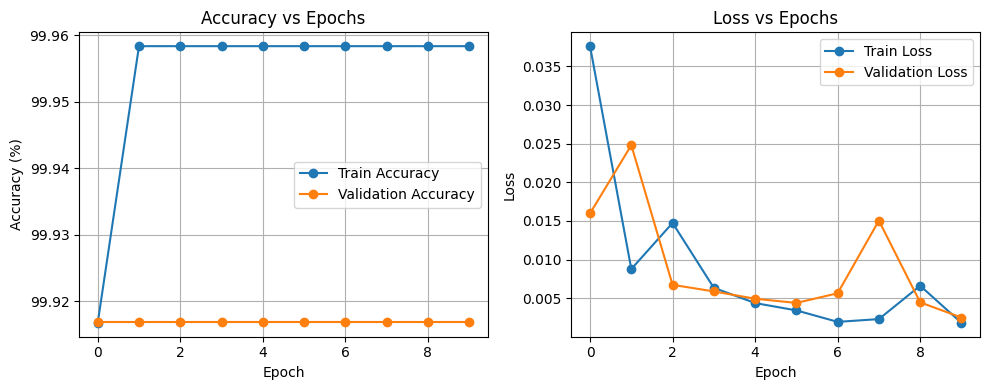

In [24]:
# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy', marker='o')
plt.plot(val_acc_list, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
# Plot Loss vs Epochs
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss', marker='o')
plt.plot(val_loss_list, label='Validation Loss', marker='o')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


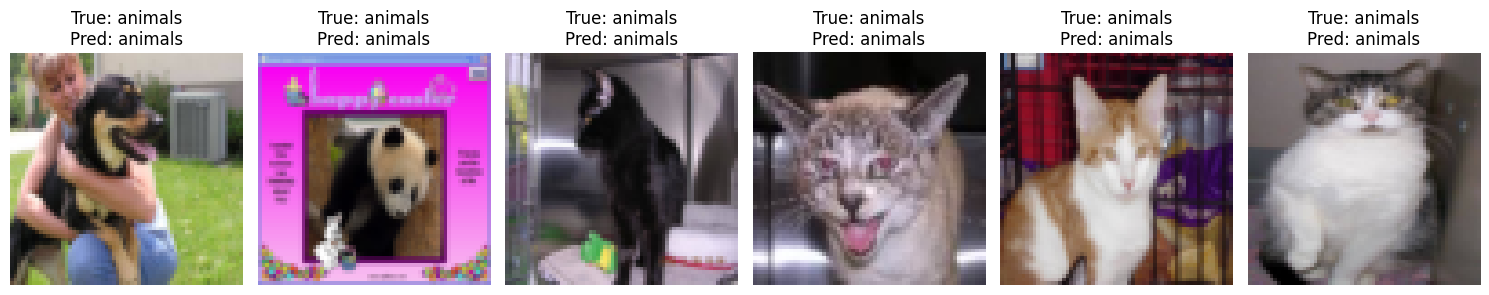

In [25]:
# Class names
class_names = dataset.classes
# Function to show sample predictions
def show_predictions(model, loader, num_images=6):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 5))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.5) + 0.5  # Unnormalize

                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()
# Show predictions on validation data
show_predictions(model, val_loader)


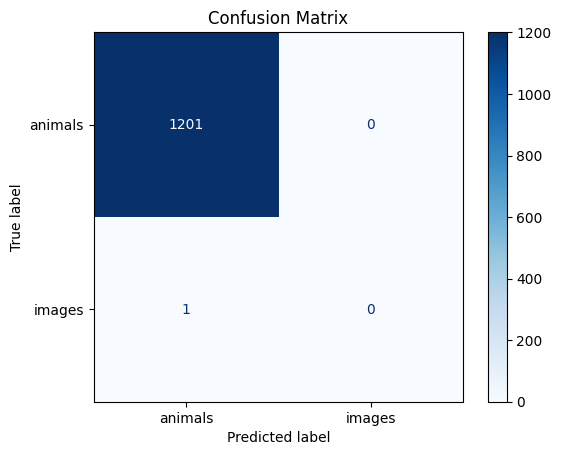

In [27]:
# Gather all predictions and true labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
